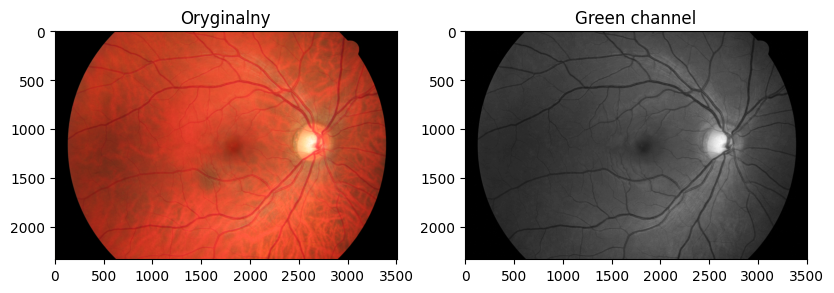

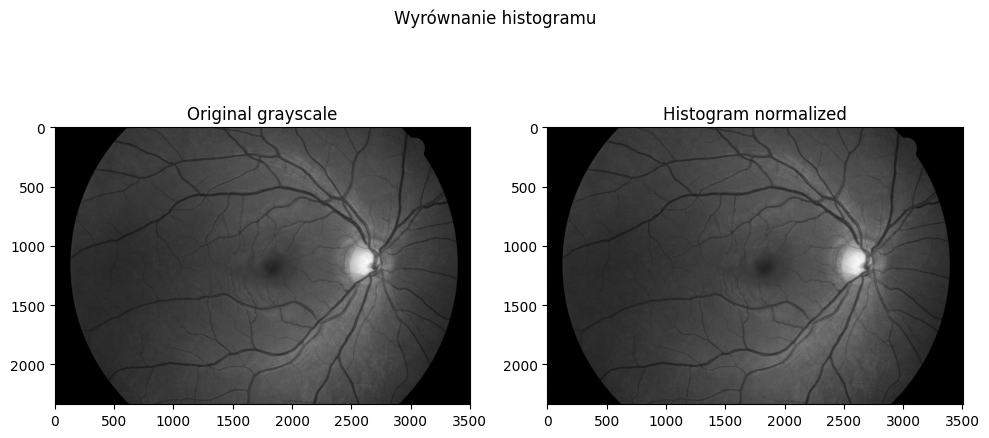

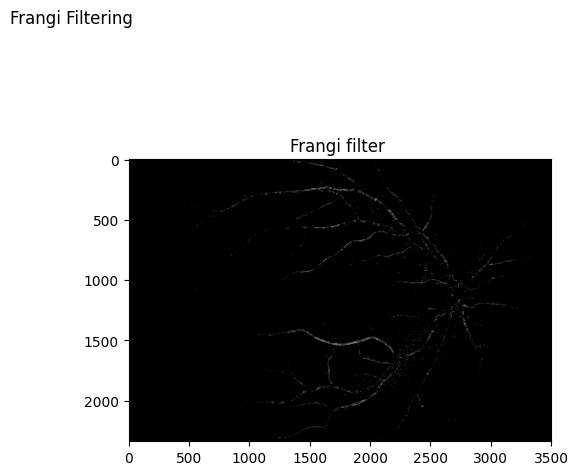

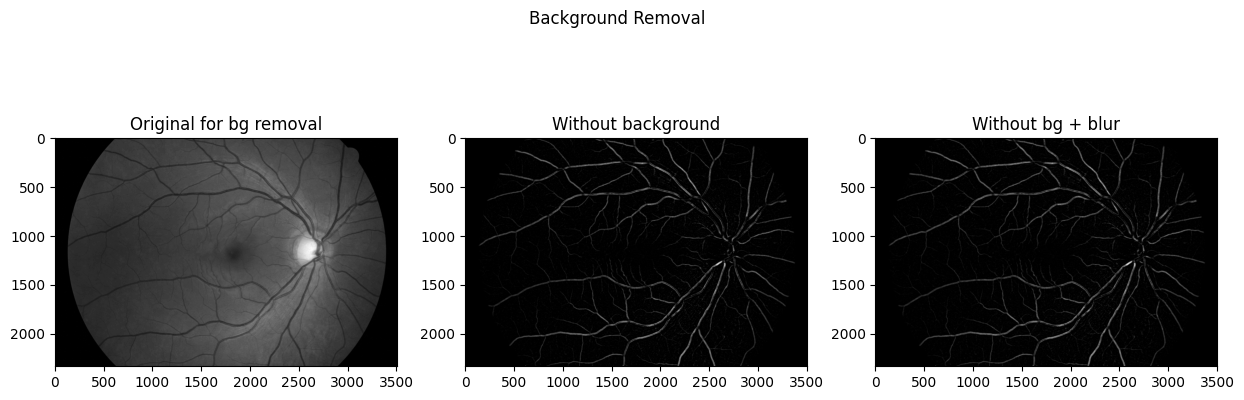

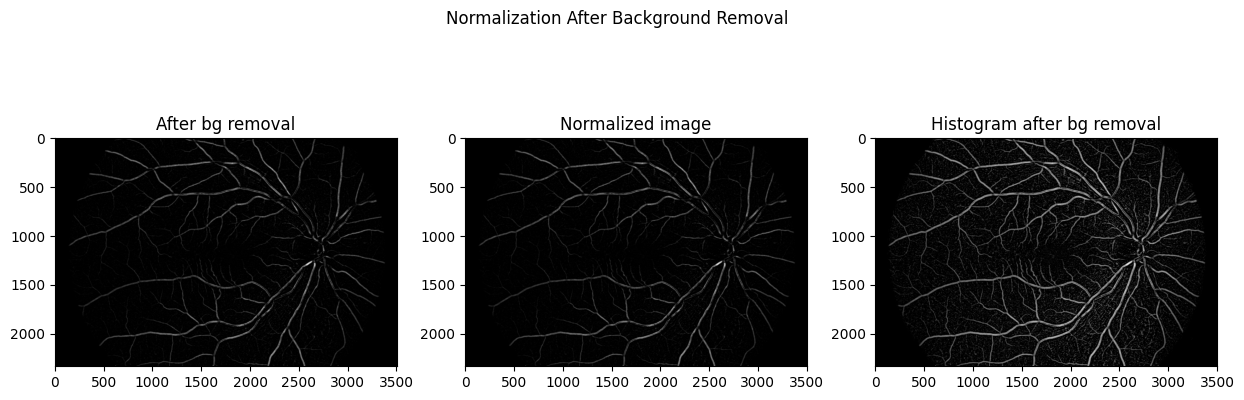

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi, gaussian
from skimage.exposure import rescale_intensity, equalize_adapthist
from skimage.morphology import opening, closing, disk
from skimage.util import img_as_ubyte

# TODO: sprawdzic czy to da sie zmienic na skimage (i hope)
def remove_image_border(color_img: np.ndarray, image: np.ndarray) -> np.ndarray:
    hsv = cv2.cvtColor(color_img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 80])
    upper = np.array([255, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    return cv2.bitwise_and(image, mask)

# 1. Wczytaj obraz
# TODO: zmienić na wczytywanie na skimage
obraz = cv2.imread('dane/obrazy/01_h.jpg')
obraz_rgb = cv2.cvtColor(obraz, cv2.COLOR_BGR2RGB)


# Figure 1: Original image and channels
fig1 = plt.figure(figsize=(15, 8))

# Original image
axis1 = fig1.add_subplot(2, 3, 1)
axis1.set_title('Oryginalny')
axis1.imshow(obraz_rgb)

# Channel visualizations
axis2 = fig1.add_subplot(2, 3, 2)
axis2.set_title('Green channel')
axis2.imshow(obraz_rgb[:, :, 1], cmap='gray')


img_green = obraz_rgb[:, :, 1]
img_green_norm = img_green / 255.0  # equalize_adapthist działa na float64, zakres [0, 1]
img_clahe = equalize_adapthist(img_green_norm, clip_limit=0.03, nbins=256)
img_clahe_uint8 = (img_clahe * 255).astype(np.uint8)

fig2 = plt.figure(figsize=(10, 5))
fig2.suptitle('Wyrównanie histogramu')

axis6 = fig2.add_subplot(1, 2, 1)
axis6.set_title('Original grayscale')
axis6.imshow(img_green, cmap='gray')

axis7 = fig2.add_subplot(1, 2, 2)
axis7.set_title('Histogram normalized')
axis7.imshow(img_green_norm, cmap='gray')

fig2.tight_layout()


# Figure 3: Frangi filter
fig3 = plt.figure(figsize=(12, 6))
fig3.suptitle('Frangi Filtering')

img_frangi = frangi(img_green_norm, sigmas=np.arange(1, 5, 0.5), black_ridges=True)
img_frangi = img_frangi / img_frangi.max()
img_frangi = np.where(img_frangi > 0.065, 1, 0)

# Apply border removal to Frangi filtered image
img_frangi_uint8 = (img_frangi * 255).astype(np.uint8)
img_frangi = remove_image_border(obraz_rgb, img_frangi_uint8)
# Convert back to binary
img_frangi = np.where(img_frangi > 0, 1, 0)


axis11 = fig3.add_subplot(1, 2, 2)
axis11.set_title('Frangi filter ')
axis11.imshow(img_frangi, cmap='gray')



# Figure 4: Morphological operations
# Konwersja obrazu do uint8 (skimage działa najlepiej w tym formacie)
img_green_uint8 = img_as_ubyte(img_green / 255.0)

# Dobór promieni (dysk o promieniu r ≈ kernel o średnicy 2r+1)
DISK_RADIUS = [2, 3, 7, 11]  # odpowiadają rozmiarom 5, 7, 15, 23
images = [img_green_uint8.copy()]

for radius in DISK_RADIUS:
    selem = disk(radius)
    new_img = opening(images[-1], selem)
    images.append(new_img.copy())
    new_img = closing(images[-1], selem)
    images.append(new_img.copy())

images = images[1:]  # Pomijamy pierwszy obraz (oryginalny), zostają tylko przekształcone

images = images[1:]


# Figure 5: Background removal
fig5 = plt.figure(figsize=(15, 5))
fig5.suptitle('Background Removal')

background = images[-1]
#TEJ LINIJKI NAJPEWNIEJ NIE MÓŻNA ZMIENIĆ CHYBA ŻE COŚ WYMYŚLE
img_no_background = cv2.subtract(background, img_green)
img_no_background_blur = gaussian(img_no_background, sigma=1, preserve_range=True)

axis14 = fig5.add_subplot(1, 3, 1)
axis14.set_title('Original for bg removal')
axis14.imshow(img_green, cmap='gray')

axis15 = fig5.add_subplot(1, 3, 2)
axis15.set_title('Without background')
axis15.imshow(img_no_background, cmap='gray')

axis16 = fig5.add_subplot(1, 3, 3)
axis16.set_title('Without bg + blur')
axis16.imshow(img_no_background_blur, cmap='gray')

# Figure 6: Normalization after background removal
fig6 = plt.figure(figsize=(15, 5))
fig6.suptitle('Normalization After Background Removal')


img_blur_float = img_no_background_blur / 255.0
img_clahe = equalize_adapthist(img_blur_float, clip_limit=0.03)
img_clahe = (img_clahe * 255).astype(np.uint8)

axis17 = fig6.add_subplot(1, 3, 1)
axis17.set_title('After bg removal')
axis17.imshow(img_no_background_blur, cmap='gray')

img_normalized = (img_no_background_blur / img_no_background_blur.max()) * 255
axis18 = fig6.add_subplot(1, 3, 2)
axis18.set_title('Normalized image')
axis18.imshow(img_normalized, cmap='gray')

axis19 = fig6.add_subplot(1, 3, 3)
axis19.set_title('Histogram after bg removal')
axis19.imshow(img_clahe, cmap='gray')


#TODO : dodać pomiary z zadania dla 5 róznych obrazów